Goal :

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
organizations_df = pd.read_csv('/content/drive/MyDrive/MRP-17/organizations.csv')
encounters_df = pd.read_csv('/content/drive/MyDrive/MRP-17/encounters.csv')
patients_df = pd.read_csv('/content/drive/MyDrive/MRP-17/patients.csv')
medications_df = pd.read_csv('/content/drive/MyDrive/MRP-17/medications.csv')
payers_df = pd.read_csv('/content/drive/MyDrive/MRP-17/payers.csv')
procedures_df = pd.read_csv('/content/drive/MyDrive/MRP-17/procedures.csv')
conditions_df = pd.read_csv('/content/drive/MyDrive/MRP-17/conditions.csv')

In [4]:
def clean_column_names(df):
    # Clean column names by:
    # 1. Converting to lowercase
    # 2. Replacing spaces with underscores
    # 3. Removing special characters (keeping only alphanumeric and underscores)
    df.columns = df.columns.str.lower()  # Convert column names to lowercase
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    return df

In [5]:
patients_df = clean_column_names(patients_df)
print(patients_df.columns)

Index(['id', 'birthdate', 'deathdate', 'ssn', 'drivers', 'passport', 'prefix',
       'first', 'middle', 'last', 'suffix', 'maiden', 'marital', 'race',
       'ethnicity', 'gender', 'birthplace', 'address', 'city', 'state',
       'county', 'fips', 'zip', 'lat', 'lon', 'healthcare_expenses',
       'healthcare_coverage', 'income'],
      dtype='object')


In [6]:
patients_df = clean_column_names(patients_df)
payers_df = clean_column_names(payers_df)
organizations_df = clean_column_names(organizations_df)
conditions_df = clean_column_names(conditions_df)
encounters_df = clean_column_names(encounters_df)
medications_df = clean_column_names(medications_df)
procedures_df = clean_column_names(procedures_df)

In [7]:
patients_df.head()

,id,birthdate,deathdate,ssn,drivers,passport,prefix,first,middle,last,...,city,state,county,fips,zip,lat,lon,healthcare_expenses,healthcare_coverage,income
0,e148a164-917e-3e86-55d3-19b033fc0dd9,1995-12-25,NaN,999-39-8922,S99945413,X41291302X,Mr.,Dick869,Mohammed454,Wiegand701,...,Redwood City,California,San Mateo County,6081.0,94070,37.495884,-122.191118,73328.15,4941.82,194919
1,23ace858-1c37-2f5b-9a65-55dd235bde48,2023-11-02,NaN,999-27-5587,NaN,NaN,NaN,Theresia791,Chloe501,Kozey370,...,Palmdale,California,Los Angeles County,6037.0,93550,34.599074,-117.801410,11454.43,666.90,48575
2,0e90aec6-b6fd-8033-3032-ccac2eed4216,2016-10-04,NaN,999-94-8985,NaN,NaN,NaN,Nyla424,Francina926,Klocko335,...,Stockton,California,San Joaquin County,6077.0,95215,38.057223,-121.384785,30154.68,4789.76,75614
3,0ec8417e-2790-64d7-1958-4101bdb8bdfe,2008-07-13,NaN,999-72-4109,S99955613,NaN,NaN,Jesús825,Adán600,Molina998,...,Murrieta,California,Riverside County,6065.0,92590,33.458028,-117.259757,1740.00,66015.09,21851
4,925e03a2-8385-ef48-517e-515ea8de3a9c,1988-07-05,NaN,999-89-4165,S99959144,X4181964X,Mr.,Derrick232,Nicky270,Boehm581,...,San Francisco,California,San Francisco County,6075.0,94158,37.732818,-122.498973,31304.21,78051.08,45757


In [8]:
patients_df['birthdate'] = pd.to_datetime(patients_df['birthdate']).dt.tz_localize(None)
encounters_df['start'] = pd.to_datetime(encounters_df['start']).dt.tz_localize(None)
conditions_df['start'] = pd.to_datetime(conditions_df['start']).dt.tz_localize(None)


In [9]:

encounters_df['out_of_pocket'] = encounters_df['total_claim_cost'] - encounters_df['payer_coverage']

In [10]:
encounters_df = encounters_df.merge(patients_df[['id', 'birthdate', 'gender', 'race', 'income', 'state', 'zip']],
                                    left_on='patient', right_on='id', suffixes=('', '_patient'))

In [11]:
encounters_df['age'] = ((encounters_df['start'] - encounters_df['birthdate']).dt.days / 365).astype(int)
encounters_df.drop(columns=['birthdate', 'id_patient'], inplace=True)

In [12]:
encounters_df = encounters_df.merge(payers_df[['id', 'name']], left_on='payer', right_on='id', suffixes=('', '_payer'))
encounters_df.rename(columns={'name': 'payer_name'}, inplace=True)
encounters_df.drop(columns=['id_payer'], inplace=True)

In [13]:
organizations_df = organizations_df[['id', 'state']].rename(columns={'state': 'org_state'})
encounters_df = encounters_df.merge(organizations_df, left_on='organization', right_on='id', how='left')
encounters_df.drop(columns=['id_y'], inplace=True)

In [14]:
procedures_df.head()

,start,stop,patient,encounter,system,code,description,base_cost,reasoncode,reasondescription
0,2023-11-02T15:43:42Z,2023-11-02T15:58:42Z,23ace858-1c37-2f5b-9a65-55dd235bde48,53e7bf57-d1dc-70fb-c09e-dda688e9cb07,http://snomed.info/sct,430193006,Medication reconciliation (procedure),1075.13,NaN,NaN
1,2018-02-27T01:51:19Z,2018-02-27T02:49:25Z,e148a164-917e-3e86-55d3-19b033fc0dd9,ee5abd84-84d1-5701-cb33-7caa69e54d7f,http://snomed.info/sct,710824005,Assessment of health and social care needs (pr...,600.50,NaN,NaN
2,2018-02-27T02:49:25Z,2018-02-27T03:05:48Z,e148a164-917e-3e86-55d3-19b033fc0dd9,ee5abd84-84d1-5701-cb33-7caa69e54d7f,http://snomed.info/sct,710841007,Assessment of anxiety (procedure),600.50,NaN,NaN
3,2018-02-27T03:05:48Z,2018-02-27T03:50:04Z,e148a164-917e-3e86-55d3-19b033fc0dd9,ee5abd84-84d1-5701-cb33-7caa69e54d7f,http://snomed.info/sct,866148006,Screening for domestic abuse (procedure),600.50,NaN,NaN
4,2018-02-27T03:50:04Z,2018-02-27T04:02:01Z,e148a164-917e-3e86-55d3-19b033fc0dd9,ee5abd84-84d1-5701-cb33-7caa69e54d7f,http://snomed.info/sct,171207006,Depression screening (procedure),600.50,NaN,NaN


In [15]:
procedures_df['patient'].value_counts()

,count
patient,
0ea923be-0532-ed97-9ca1-d908fd3a832c,1780
66932a17-d6ca-3354-dd3c-553b341e4cb1,1770
19aa8ff6-8e4d-0300-1373-cbebfe99034a,1769
b18a66fb-def0-7fd6-b5d9-6abaf0a94a3b,1618
85895f67-9f46-4de4-1a62-73646286ea41,1590
...,...
49b0486f-cb15-4a39-5bf8-bd6d3b885dd1,2
f734daef-de74-5d6f-ab1e-33ef82f2ba6c,2
e1b0c206-3407-f0e1-0e98-2cb9aee23295,2


In [16]:
# Aggregate procedures per encounter
proc_agg = procedures_df.groupby('encounter').agg(
    num_procedures=('code', 'count'),
    total_proc_base_cost=('base_cost', 'sum')
).reset_index()

# Aggregate medications per encounter
med_agg = medications_df.groupby('encounter').agg(
    num_medications=('code', 'count'),
    total_med_base_cost=('base_cost', 'sum')
).reset_index()

In [17]:
encounters_df.columns

Index(['id_x', 'start', 'stop', 'patient', 'organization', 'provider', 'payer',
       'encounterclass', 'code', 'description', 'base_encounter_cost',
       'total_claim_cost', 'payer_coverage', 'reasoncode', 'reasondescription',
       'out_of_pocket', 'gender', 'race', 'income', 'state', 'zip', 'age',
       'payer_name', 'org_state'],
      dtype='object')

In [18]:
# Rename the encounter ID column
encounters_df.rename(columns={'id_x': 'encounter'}, inplace=True)

In [19]:
# Now, merge this merged_agg with encounters_df
encounters_df = encounters_df.merge(med_agg, on='encounter', how='left')

In [20]:
encounters_df.columns

Index(['encounter', 'start', 'stop', 'patient', 'organization', 'provider',
       'payer', 'encounterclass', 'code', 'description', 'base_encounter_cost',
       'total_claim_cost', 'payer_coverage', 'reasoncode', 'reasondescription',
       'out_of_pocket', 'gender', 'race', 'income', 'state', 'zip', 'age',
       'payer_name', 'org_state', 'num_medications', 'total_med_base_cost'],
      dtype='object')

In [21]:
# Now, merge this merged_agg with encounters_df
encounters_df = encounters_df.merge(proc_agg, on='encounter', how='inner')

In [22]:
encounters_df.columns

Index(['encounter', 'start', 'stop', 'patient', 'organization', 'provider',
       'payer', 'encounterclass', 'code', 'description', 'base_encounter_cost',
       'total_claim_cost', 'payer_coverage', 'reasoncode', 'reasondescription',
       'out_of_pocket', 'gender', 'race', 'income', 'state', 'zip', 'age',
       'payer_name', 'org_state', 'num_medications', 'total_med_base_cost',
       'num_procedures', 'total_proc_base_cost'],
      dtype='object')

In [23]:
encounters_df[encounters_df['payer_name'] == 'NO_INSURANCE']

,encounter,start,stop,patient,organization,provider,payer,encounterclass,code,description,...,income,state,zip,age,payer_name,org_state,num_medications,total_med_base_cost,num_procedures,total_proc_base_cost
188,2d4b7b17-3a30-6d5d-0398-bbaa516d2d29,2017-02-05 00:39:42,2017-02-05T00:54:42Z,e2419c63-6e20-e937-616f-40da3636ee05,627080f7-e0a8-32d7-b7df-302c910b656b,88e1db09-788b-35d9-9f6d-8d183f826814,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185345009,Encounter for symptom (procedure),...,56762,California,90064,9,NO_INSURANCE,CA,NaN,NaN,1,1201.00
189,b2351642-65b2-b2da-906f-7bc5b2f6ab03,2018-02-01 17:39:42,2018-02-01T17:56:01Z,e2419c63-6e20-e937-616f-40da3636ee05,0f870a5f-fe82-32e6-95c3-eddd83e8fa47,7edd8743-3454-3e2e-83fb-f12dab0b6edc,e03e23c9-4df1-3eb6-a62d-f70f02301496,wellness,410620009,Well child visit (procedure),...,56762,California,90064,10,NO_INSURANCE,CA,NaN,NaN,1,600.50
190,7749e0ab-4740-633a-eaa9-961e4d09c8e3,2018-02-08 17:39:42,2018-02-09T01:08:53Z,e2419c63-6e20-e937-616f-40da3636ee05,627080f7-e0a8-32d7-b7df-302c910b656b,88e1db09-788b-35d9-9f6d-8d183f826814,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185349003,Encounter for check up (procedure),...,56762,California,90064,10,NO_INSURANCE,CA,1.0,260.78,12,7206.00
191,0bfa4f91-9fe7-f232-dd9f-2092bb46a328,2019-02-07 17:39:42,2019-02-07T17:54:42Z,e2419c63-6e20-e937-616f-40da3636ee05,0f870a5f-fe82-32e6-95c3-eddd83e8fa47,7edd8743-3454-3e2e-83fb-f12dab0b6edc,e03e23c9-4df1-3eb6-a62d-f70f02301496,wellness,410620009,Well child visit (procedure),...,56762,California,90064,11,NO_INSURANCE,CA,NaN,NaN,1,600.50
192,f36af958-bb53-4f4a-bf04-68b5b50b3f13,2019-02-14 17:39:42,2019-02-14T21:35:24Z,e2419c63-6e20-e937-616f-40da3636ee05,627080f7-e0a8-32d7-b7df-302c910b656b,88e1db09-788b-35d9-9f6d-8d183f826814,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185349003,Encounter for check up (procedure),...,56762,California,90064,11,NO_INSURANCE,CA,1.0,260.78,8,4804.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47046,08d735cb-c7ec-e8b0-eaa0-3e2a6441f5f3,2021-03-03 18:55:44,2021-03-03T19:28:06Z,64059323-6ac6-1ced-ce7e-7e5830a3f10c,b9584c48-7dc8-342e-b583-3149f90c38df,c96d14db-f2cb-3b6b-b82e-f515b2786157,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185347001,Encounter for problem (procedure),...,58729,California,95122,57,NO_INSURANCE,CA,NaN,NaN,1,1773.87
47047,3a5818c9-0b5d-807f-2ab7-6fdcea687b62,2021-03-04 19:36:06,2021-03-04T20:04:24Z,64059323-6ac6-1ced-ce7e-7e5830a3f10c,b9584c48-7dc8-342e-b583-3149f90c38df,c96d14db-f2cb-3b6b-b82e-f515b2786157,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185347001,Encounter for problem (procedure),...,58729,California,95122,57,NO_INSURANCE,CA,NaN,NaN,1,594.49
47048,8706af4a-7fb3-883a-1dfb-89438525aaa4,2021-03-06 06:47:24,2021-03-06T07:09:17Z,64059323-6ac6-1ced-ce7e-7e5830a3f10c,b9584c48-7dc8-342e-b583-3149f90c38df,c96d14db-f2cb-3b6b-b82e-f515b2786157,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185347001,Encounter for problem (procedure),...,58729,California,95122,57,NO_INSURANCE,CA,NaN,NaN,1,1344.74
47049,7ad2be38-9f60-ec3a-b257-dc935d0574ce,2021-03-07 18:44:17,2021-03-07T19:13:58Z,64059323-6ac6-1ced-ce7e-7e5830a3f10c,b9584c48-7dc8-342e-b583-3149f90c38df,c96d14db-f2cb-3b6b-b82e-f515b2786157,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185347001,Encounter for problem (procedure),...,58729,California,95122,57,NO_INSURANCE,CA,NaN,NaN,1,594.49


In [24]:

# Fill NaNs from meds/procs with 0
encounters_df[['num_procedures', 'total_proc_base_cost',
               'num_medications', 'total_med_base_cost']] = encounters_df[[
    'num_procedures', 'total_proc_base_cost',
    'num_medications', 'total_med_base_cost'
]].fillna(0)

In [25]:
# Historical condition counts (before each encounter)
conditions_df['start'] = pd.to_datetime(conditions_df['start'])

def count_prior_conditions(row):
    return conditions_df[
        (conditions_df['patient'] == row['patient']) &
        (conditions_df['start'] < row['start'])
    ].shape[0]

encounters_df['num_prior_conditions'] = encounters_df.apply(count_prior_conditions, axis=1)

In [26]:
# Final columns to keep
selected_cols = [
    'encounter', 'patient', 'payer_name', 'org_state',
    'age', 'gender', 'race', 'income', 'state', 'zip',
    'encounterclass', 'code', 'description', 'reasoncode', 'reasondescription',
    'base_encounter_cost', 'num_procedures', 'total_proc_base_cost',
    'num_medications', 'total_med_base_cost',
    'num_prior_conditions',
    'out_of_pocket'
]

final_df = encounters_df[selected_cols]

In [27]:
final_df

,encounter,patient,payer_name,org_state,age,gender,race,income,state,zip,...,description,reasoncode,reasondescription,base_encounter_cost,num_procedures,total_proc_base_cost,num_medications,total_med_base_cost,num_prior_conditions,out_of_pocket
0,53e7bf57-d1dc-70fb-c09e-dda688e9cb07,23ace858-1c37-2f5b-9a65-55dd235bde48,Aetna,CA,0,F,white,48575,California,93550,...,Well child visit (procedure),NaN,NaN,146.76,1,1075.13,0.0,0.0,1,1477.82
1,ee5abd84-84d1-5701-cb33-7caa69e54d7f,e148a164-917e-3e86-55d3-19b033fc0dd9,Humana,CA,22,M,white,194919,California,94070,...,General examination of patient (procedure),NaN,NaN,146.76,7,4203.50,0.0,0.0,8,1607.80
2,cbf430bd-010c-a41d-84b6-3f6679b70d7b,e148a164-917e-3e86-55d3-19b033fc0dd9,Humana,CA,22,M,white,194919,California,94070,...,Encounter for problem (procedure),271737000.0,Anemia (disorder),82.02,4,1356.73,0.0,0.0,8,1558.68
3,03623224-09e9-449e-7af3-984b4e1ecb94,e148a164-917e-3e86-55d3-19b033fc0dd9,Humana,CA,25,M,white,194919,California,94070,...,General examination of patient (procedure),NaN,NaN,146.76,4,3002.50,0.0,0.0,10,2212.39
4,9e8103fd-7ed6-9e94-17db-8bed50f59734,23ace858-1c37-2f5b-9a65-55dd235bde48,Aetna,CA,0,F,white,48575,California,93550,...,Well child visit (procedure),NaN,NaN,146.76,1,746.29,0.0,0.0,3,1573.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47962,2eab17ad-6b2d-3633-0fab-679fc6974510,f7abf642-da27-635e-2ca6-d1c9449c048a,Medicare,CA,74,F,asian,146847,California,91006,...,General examination of patient (procedure),NaN,NaN,146.76,5,3002.50,0.0,0.0,25,387.04
47963,6ccb3866-1b01-c3ae-130f-33994a3980aa,f7abf642-da27-635e-2ca6-d1c9449c048a,Medicare,CA,75,F,asian,146847,California,91006,...,Admission to hospice (procedure),26929004.0,Alzheimer's disease (disorder),171.83,17,10208.50,0.0,0.0,25,2262.47
47964,8c2b095a-3f0b-7a3b-b4a4-69011fd9f1cc,f7abf642-da27-635e-2ca6-d1c9449c048a,Medicare,CA,75,F,asian,146847,California,91006,...,General examination of patient (procedure),NaN,NaN,146.76,5,2702.25,0.0,0.0,27,236.70
47965,2c8b26df-4ff3-d1e1-2319-989391882c83,f7abf642-da27-635e-2ca6-d1c9449c048a,Medicare,CA,76,F,asian,146847,California,91006,...,General examination of patient (procedure),NaN,NaN,146.76,8,4804.00,0.0,0.0,29,363.05


In [28]:
final_df.drop(columns=['reasoncode', 'reasondescription', 'state', 'org_state', 'zip', 'encounter', 'patient', 'description'], inplace=True)

<ipython-input-28-970446d6fc96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop(columns=['reasoncode', 'reasondescription', 'state', 'org_state', 'zip', 'encounter', 'patient', 'description'], inplace=True)


In [29]:
final_df.columns

Index(['payer_name', 'age', 'gender', 'race', 'income', 'encounterclass',
       'code', 'base_encounter_cost', 'num_procedures', 'total_proc_base_cost',
       'num_medications', 'total_med_base_cost', 'num_prior_conditions',
       'out_of_pocket'],
      dtype='object')

In [30]:
final_df = final_df[final_df['age'].fillna(0) > 0]

In [31]:
final_df

,payer_name,age,gender,race,income,encounterclass,code,base_encounter_cost,num_procedures,total_proc_base_cost,num_medications,total_med_base_cost,num_prior_conditions,out_of_pocket
1,Humana,22,M,white,194919,wellness,162673000,146.76,7,4203.50,0.0,0.0,8,1607.80
2,Humana,22,M,white,194919,ambulatory,185347001,82.02,4,1356.73,0.0,0.0,8,1558.68
3,Humana,25,M,white,194919,wellness,162673000,146.76,4,3002.50,0.0,0.0,10,2212.39
5,Humana,25,M,white,194919,ambulatory,185345009,82.02,1,1201.00,0.0,0.0,11,1283.02
7,Humana,28,M,white,194919,wellness,162673000,146.76,4,2101.75,0.0,0.0,14,1423.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47962,Medicare,74,F,asian,146847,wellness,162673000,146.76,5,3002.50,0.0,0.0,25,387.04
47963,Medicare,75,F,asian,146847,hospice,305336008,171.83,17,10208.50,0.0,0.0,25,2262.47
47964,Medicare,75,F,asian,146847,wellness,162673000,146.76,5,2702.25,0.0,0.0,27,236.70
47965,Medicare,76,F,asian,146847,wellness,162673000,146.76,8,4804.00,0.0,0.0,29,363.05


In [32]:
final_df.columns

Index(['payer_name', 'age', 'gender', 'race', 'income', 'encounterclass',
       'code', 'base_encounter_cost', 'num_procedures', 'total_proc_base_cost',
       'num_medications', 'total_med_base_cost', 'num_prior_conditions',
       'out_of_pocket'],
      dtype='object')

In [33]:
# Optional: Save to CSV
final_df.to_csv('/content/drive/MyDrive/MRP-17/final_training_dataset.csv', index=False)

In [34]:
final_df = pd.read_csv('/content/drive/MyDrive/MRP-17/final_training_dataset.csv')

In [35]:
final_df.shape

(47512, 14)

In [36]:
final_df

,payer_name,age,gender,race,income,encounterclass,code,base_encounter_cost,num_procedures,total_proc_base_cost,num_medications,total_med_base_cost,num_prior_conditions,out_of_pocket
0,Humana,22,M,white,194919,wellness,162673000,146.76,7,4203.50,0.0,0.0,8,1607.80
1,Humana,22,M,white,194919,ambulatory,185347001,82.02,4,1356.73,0.0,0.0,8,1558.68
2,Humana,25,M,white,194919,wellness,162673000,146.76,4,3002.50,0.0,0.0,10,2212.39
3,Humana,25,M,white,194919,ambulatory,185345009,82.02,1,1201.00,0.0,0.0,11,1283.02
4,Humana,28,M,white,194919,wellness,162673000,146.76,4,2101.75,0.0,0.0,14,1423.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47507,Medicare,74,F,asian,146847,wellness,162673000,146.76,5,3002.50,0.0,0.0,25,387.04
47508,Medicare,75,F,asian,146847,hospice,305336008,171.83,17,10208.50,0.0,0.0,25,2262.47
47509,Medicare,75,F,asian,146847,wellness,162673000,146.76,5,2702.25,0.0,0.0,27,236.70
47510,Medicare,76,F,asian,146847,wellness,162673000,146.76,8,4804.00,0.0,0.0,29,363.05


In [37]:
!pip install scikit-learn==1.3.2
!pip install --upgrade xgboost scikit-learn
!pip install xgboost==1.7.6 scikit-learn==1.3.2
!pip install numpy==1.26.4


  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached xgboost-1.7.6-py3-none

In [38]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install scipy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [39]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns for Label Encoding
label_cols = ['payer_name', 'gender', 'race', 'encounterclass']

# Initialize a dictionary to store the encoders for each column
encoder_dict = {}

# Apply Label Encoding to each column and store the encoder for each
for col in label_cols:
    encoder = LabelEncoder()
    final_df[col] = encoder.fit_transform(final_df[col])
    encoder_dict[col] = encoder  # Store encoder for future reference

# Check the mappings for each column
for col in label_cols:
    print(f"Label Encoding for {col}:")
    print(dict(zip(encoder_dict[col].classes_, range(len(encoder_dict[col].classes_)))))
    print("\n")


Label Encoding for payer_name:
{'Aetna': 0, 'Anthem': 1, 'Blue Cross Blue Shield': 2, 'Cigna Health': 3, 'Dual Eligible': 4, 'Humana': 5, 'Medicaid': 6, 'Medicare': 7, 'NO_INSURANCE': 8, 'UnitedHealthcare': 9}


Label Encoding for gender:
{'F': 0, 'M': 1}


Label Encoding for race:
{'asian': 0, 'black': 1, 'hawaiian': 2, 'native': 3, 'other': 4, 'white': 5}


Label Encoding for encounterclass:
{'ambulatory': 0, 'emergency': 1, 'home': 2, 'hospice': 3, 'inpatient': 4, 'outpatient': 5, 'snf': 6, 'urgentcare': 7, 'virtual': 8, 'wellness': 9}




In [40]:
final_df

,payer_name,age,gender,race,income,encounterclass,code,base_encounter_cost,num_procedures,total_proc_base_cost,num_medications,total_med_base_cost,num_prior_conditions,out_of_pocket
0,5,22,1,5,194919,9,162673000,146.76,7,4203.50,0.0,0.0,8,1607.80
1,5,22,1,5,194919,0,185347001,82.02,4,1356.73,0.0,0.0,8,1558.68
2,5,25,1,5,194919,9,162673000,146.76,4,3002.50,0.0,0.0,10,2212.39
3,5,25,1,5,194919,0,185345009,82.02,1,1201.00,0.0,0.0,11,1283.02
4,5,28,1,5,194919,9,162673000,146.76,4,2101.75,0.0,0.0,14,1423.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47507,7,74,0,0,146847,9,162673000,146.76,5,3002.50,0.0,0.0,25,387.04
47508,7,75,0,0,146847,3,305336008,171.83,17,10208.50,0.0,0.0,25,2262.47
47509,7,75,0,0,146847,9,162673000,146.76,5,2702.25,0.0,0.0,27,236.70
47510,7,76,0,0,146847,9,162673000,146.76,8,4804.00,0.0,0.0,29,363.05


# Cleaning Dataset

In [41]:
# 1. Drop duplicate rows
final_df.drop_duplicates(inplace=True)

# 2. Handle missing values
# Option 1: Drop rows with any nulls
final_df.dropna(inplace=True)

# OR Option 2: (if you want to be selective)
# final_df.fillna({'column1': value1, 'column2': value2}, inplace=True)

# 3. Ensure correct data types
# For example, convert income to float if needed
final_df['income'] = final_df['income'].astype(float)
final_df['base_encounter_cost'] = final_df['base_encounter_cost'].astype(float)
final_df['total_proc_base_cost'] = final_df['total_proc_base_cost'].astype(float)
final_df['total_med_base_cost'] = final_df['total_med_base_cost'].astype(float)
final_df['out_of_pocket'] = final_df['out_of_pocket'].astype(float)

# 4. Remove rows with age == 0 (you already mentioned this)
final_df = final_df[final_df['age'] > 0]

# Optional: Remove outliers in 'out_of_pocket' if needed
# You could use IQR or a simple threshold like:
# final_df = final_df[final_df['out_of_pocket'] < 100000]

# 5. Reset index
final_df.reset_index(drop=True, inplace=True)

# 6. Final shape and summary
print("🧼 Cleaned dataset shape:", final_df.shape)
print("📊 Missing values per column:\n", final_df.isnull().sum())


🧼 Cleaned dataset shape: (40339, 14)
📊 Missing values per column:
 payer_name              0
age                     0
gender                  0
race                    0
income                  0
encounterclass          0
code                    0
base_encounter_cost     0
num_procedures          0
total_proc_base_cost    0
num_medications         0
total_med_base_cost     0
num_prior_conditions    0
out_of_pocket           0
dtype: int64


In [42]:
final_df

,payer_name,age,gender,race,income,encounterclass,code,base_encounter_cost,num_procedures,total_proc_base_cost,num_medications,total_med_base_cost,num_prior_conditions,out_of_pocket
0,5,22,1,5,194919.0,9,162673000,146.76,7,4203.50,0.0,0.0,8,1607.80
1,5,22,1,5,194919.0,0,185347001,82.02,4,1356.73,0.0,0.0,8,1558.68
2,5,25,1,5,194919.0,9,162673000,146.76,4,3002.50,0.0,0.0,10,2212.39
3,5,25,1,5,194919.0,0,185345009,82.02,1,1201.00,0.0,0.0,11,1283.02
4,5,28,1,5,194919.0,9,162673000,146.76,4,2101.75,0.0,0.0,14,1423.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40334,7,74,0,0,146847.0,9,162673000,146.76,5,3002.50,0.0,0.0,25,387.04
40335,7,75,0,0,146847.0,3,305336008,171.83,17,10208.50,0.0,0.0,25,2262.47
40336,7,75,0,0,146847.0,9,162673000,146.76,5,2702.25,0.0,0.0,27,236.70
40337,7,76,0,0,146847.0,9,162673000,146.76,8,4804.00,0.0,0.0,29,363.05


# Correlation Columns

🔗 Correlation with out_of_pocket:

out_of_pocket           1.000000
total_proc_base_cost    0.552970
num_procedures          0.316406
base_encounter_cost     0.081865
income                  0.032285
race                    0.023004
payer_name              0.016832
num_medications         0.005599
total_med_base_cost     0.004600
code                    0.003560
gender                 -0.042537
encounterclass         -0.057389
age                    -0.122470
num_prior_conditions   -0.122677
Name: out_of_pocket, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


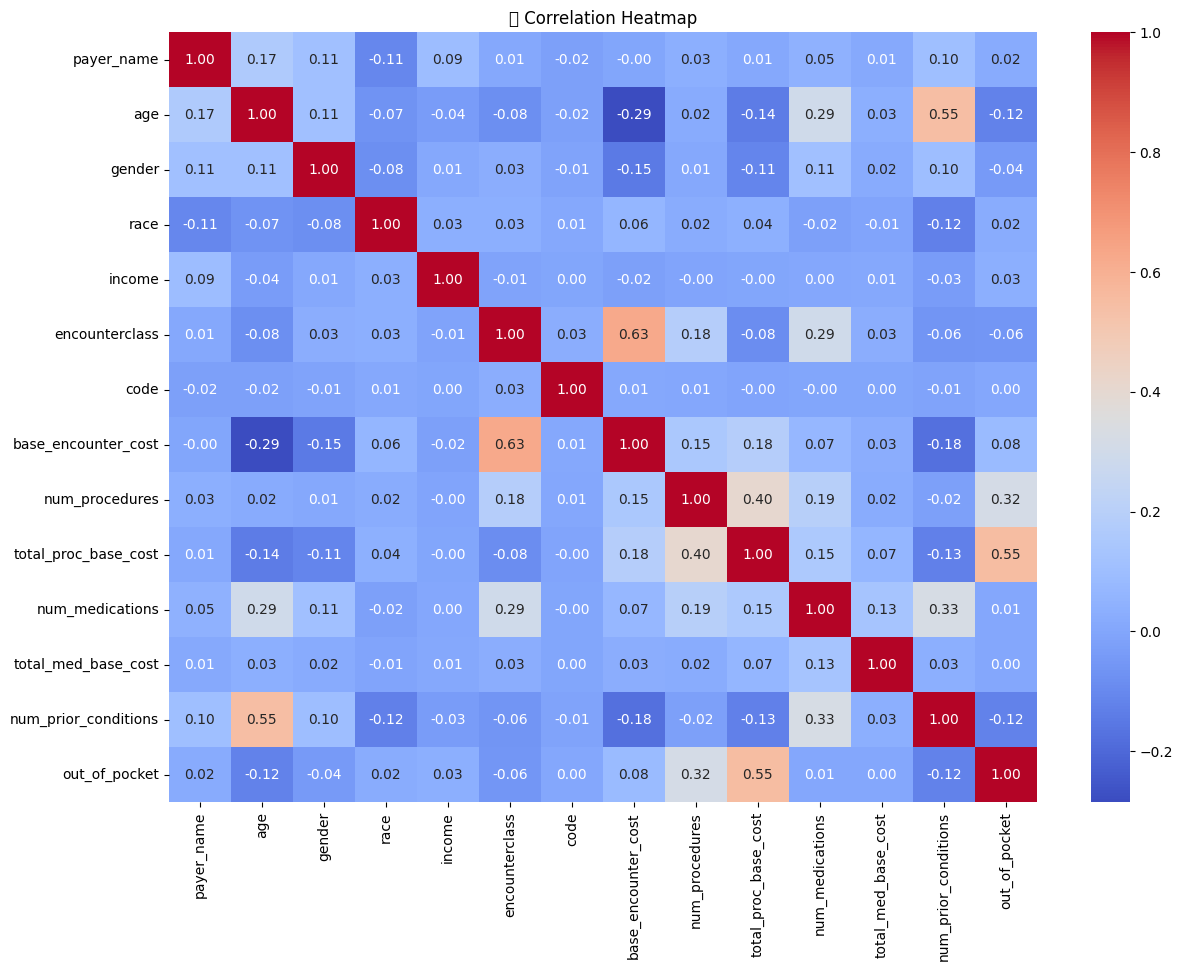

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = final_df.corr(numeric_only=True)

# Display correlations with target variable
print("🔗 Correlation with out_of_pocket:\n")
print(corr_matrix["out_of_pocket"].sort_values(ascending=False))

# Optional: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("📊 Correlation Heatmap")
plt.show()


# Checking Multi Collinearity

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned DataFrame from earlier step (assuming it's named final_df)
# For this step, let's simulate the DataFrame structure based on the last confirmed column list
# You can replace this block with actual final_df if running interactively with data

# Simulating relevant columns for multicollinearity testing
columns = ['age', 'gender', 'race', 'income', 'encounterclass',
           'base_encounter_cost', 'num_procedures', 'total_proc_base_cost',
           'num_medications', 'total_med_base_cost', 'num_prior_conditions']

# Let's assume final_df is available in session and contains the above columns
# We'll calculate the Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Create a new DataFrame with only the selected features
X = final_df[columns].copy()
X_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i + 1) for i in range(X.shape[1])]

vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
4,encounterclass,2.192317
5,base_encounter_cost,2.060353
0,age,1.579257
10,num_prior_conditions,1.547487
7,total_proc_base_cost,1.499369
8,num_medications,1.457979
6,num_procedures,1.293676
1,gender,1.064975
2,race,1.023709
9,total_med_base_cost,1.020067


Now that the dataset is clean and multicollinearity is not a concern, We can Proceed Further

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the features and target variable
features = ['age','gender', 'race', 'income', 'encounterclass',
            'base_encounter_cost', 'num_procedures', 'total_proc_base_cost', 'num_prior_conditions']

target = 'out_of_pocket'

# Feature matrix and target variable
X = final_df[features]
y = final_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 650.5425986854482
RMSE: 2070.6645411829873
R² Score: 0.4924199453726382


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import pandas as pd

# Define features and target
features = ['payer_name','age','gender', 'race', 'income', 'encounterclass',
            'base_encounter_cost', 'num_procedures', 'total_proc_base_cost', 'num_prior_conditions']
target = 'out_of_pocket'

X = final_df[features]
y = final_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df.sort_values("R²", ascending=False))


               Model          MAE         RMSE        R²
1      Random Forest   368.273305  1208.160553  0.827204
3            XGBoost   427.294523  1236.019324  0.819143
2  Gradient Boosting   651.709543  1386.669967  0.772369
4                KNN   861.000690  2361.039489  0.340080
0  Linear Regression  1048.827088  2393.122136  0.322023


In [47]:
!pip install --upgrade xgboost scikit-learn

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [48]:
#!pip install xgboost==1.7.6 scikit-learn==1.3.2

In [49]:
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [50]:
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned XGBoost - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Tuned XGBoost - MAE: 374.48, RMSE: 1264.28, R²: 0.8108


In [51]:
import joblib

joblib.dump(best_xgb, "xgboost_tuned_model.pkl")


['xgboost_tuned_model.pkl']

In [52]:
pip install optuna

In [53]:
pip install --upgrade xgboost

In [54]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import pandas as pd

# Dummy dataset placeholder (replace with your data)
# X, y = your_dataframe.drop('target', axis=1), your_dataframe['target']
# For demonstration
X = pd.DataFrame([[i] * 5 for i in range(100)], columns=[f'feat{i}' for i in range(5)])
y = pd.Series([i + 0.5 for i in range(100)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 3),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters from the study
best_params = study.best_trial.params
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

# Train a new model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Now you can use it to predict
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE on Test Set:", mae)

print("Best trial:")
print(study.best_trial.params)


[I 2025-05-06 05:53:59,477] A new study created in memory with name: no-name-d637b10c-3293-4e25-917d-3228567ce21f
[I 2025-05-06 05:53:59,841] Trial 0 finished with value: 1.392831814289093 and parameters: {'n_estimators': 405, 'max_depth': 8, 'learning_rate': 0.20087524459376263, 'subsample': 0.856254856731869, 'colsample_bytree': 0.9911954891020185, 'gamma': 1.7474807336929832, 'reg_alpha': 0.7771756818903145, 'reg_lambda': 2.0621786430319773}. Best is trial 0 with value: 1.392831814289093.
[I 2025-05-06 05:54:00,057] Trial 1 finished with value: 1.0283271074295044 and parameters: {'n_estimators': 377, 'max_depth': 6, 'learning_rate': 0.10079864883297887, 'subsample': 0.7091204058475902, 'colsample_bytree': 0.6076167018678578, 'gamma': 4.665136681203343, 'reg_alpha': 0.9290405251859398, 'reg_lambda': 2.222825881088708}. Best is trial 1 with value: 1.0283271074295044.
[I 2025-05-06 05:54:00,234] Trial 2 finished with value: 0.7526150703430176 and parameters: {'n_estimators': 371, 'max_

MAE on Test Set: 0.3779042959213257
Best trial:
{'n_estimators': 366, 'max_depth': 3, 'learning_rate': 0.01616699680366047, 'subsample': 0.6574102637843386, 'colsample_bytree': 0.7268153792611025, 'gamma': 2.434521258536123, 'reg_alpha': 0.4848876682348859, 'reg_lambda': 1.9764100293905114}


In [55]:
from sklearn.metrics import mean_absolute_error

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE on Test Set:", mae)

MAE on Test Set: 0.3779042959213257


In [56]:
!pip install --upgrade xgboost

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Create dummy data (replace with your actual dataset)
X = pd.DataFrame([[i]*5 for i in range(100)], columns=[f'feat{i}' for i in range(5)])
y = pd.Series([i + 1 for i in range(100)])  # +1 to avoid log(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log-transform target
y_train_log = np.log1p(y_train)

# Clean instance of XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2],
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=5,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

# Fit on log-transformed data
random_search.fit(X_train, y_train_log)

# Predict and transform back
y_pred_log = random_search.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print("MSE with log-transformed target:", mse)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
MSE with log-transformed target: 36.96040165892738


In [58]:
import numpy as np

# Before training:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Fit model on y_train_log instead of y_train
random_search.fit(X_train, y_train_log)

# Predict and transform back:
y_pred_log = random_search.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
print("MSE with log-transformed target:", mse)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
MSE with log-transformed target: 36.96040165892738


In [59]:
import xgboost as xgb
import joblib

# Assuming your model is already trained
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Save the model
joblib.dump(xgb_model, 'xgboost_out_of_pocket_model.pkl')

['xgboost_out_of_pocket_model.pkl']

In [60]:
pip install gradio

In [61]:
import gradio as gr
import joblib
import numpy as np

# Load your trained XGBoost model
model = joblib.load("xgboost_out_of_pocket_model.pkl")

# Label encoding maps
payer_map = {'Aetna': 0, 'Anthem': 1, 'Blue Cross Blue Shield': 2, 'Cigna Health': 3,
             'Dual Eligible': 4, 'Humana': 5, 'Medicaid': 6, 'Medicare': 7,
             'NO_INSURANCE': 8, 'UnitedHealthcare': 9}

gender_map = {'F': 0, 'M': 1}
race_map = {'asian': 0, 'black': 1, 'hawaiian': 2, 'native': 3, 'other': 4, 'white': 5}
#ethnicity_map = {'hispanic': 0, 'nonhispanic': 1}
encounterclass_map = {'ambulatory': 0, 'emergency': 1, 'home': 2, 'inpatient': 3,
                      'outpatient': 4, 'urgentcare': 5, 'virtual': 6, 'wellness': 7}

# Prediction function
def predict_cost(age, gender, race, ethnicity, income, encounterclass,
                 base_encounter_cost, num_procedures, total_proc_base_cost,
                 num_prior_conditions,
                 ):

    input_data = np.array([[
        age,
        gender_map[gender],
        race_map[race],
#        ethnicity_map[ethnicity],
        income,
        encounterclass_map[encounterclass],
        base_encounter_cost,
        num_procedures,
        total_proc_base_cost,

        num_prior_conditions,
        #payer_map[payer_name]
    ]])

    prediction = model.predict(input_data)[0]
    return f"Estimated Out-of-Pocket Cost: ${prediction:.2f}"

# Gradio UI
inputs = [
    gr.Slider(0, 100, label="Age"),
    gr.Dropdown(choices=list(gender_map.keys()), label="Gender"),
    gr.Dropdown(choices=list(race_map.keys()), label="Race"),
    #gr.Dropdown(choices=list(ethnicity_map.keys()), label="Ethnicity"),
    gr.Number(label="Income"),
    gr.Dropdown(choices=list(encounterclass_map.keys()), label="Encounter Class"),
    gr.Number(label="Base Encounter Cost"),
    gr.Number(label="Number of Procedures"),
    gr.Number(label="Total Procedure Base Cost"),

    gr.Number(label="Number of Prior Conditions"),
    gr.Dropdown(choices=list(payer_map.keys()), label="Payer Name")
]

gr.Interface(
    fn=predict_cost,
    inputs=inputs,
    outputs="text",
    title="Out-of-Pocket Cost Estimator",
    description="Estimate the out-of-pocket cost based on patient info and encounter details using XGBoost model."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d701aa425b7063a1bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [62]:
import joblib

# Define the path to save in Google Drive
model_path = '/content/drive/MyDrive/MRP-17/random_forest_model.pkl'

# Save the model
joblib.dump(models["Random Forest"], model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/MRP-17/random_forest_model.pkl


In [66]:
# Re-import required modules after kernel reset
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor

# Load the trained model
model_path = "/content/drive/MyDrive/MRP-17/random_forest_model.pkl"
rf_model = joblib.load(model_path)

# Sample input matching the features used during training
sample_input = pd.DataFrame([{
    'payer_name': 0,
    'age': 45,
    'gender': 1,  # encoded
    'race': 2,    # encoded
    'income': 55000,
    'encounterclass': 4,  # outpatient
    'base_encounter_cost': 1000.0,
    'num_procedures': 2,
    'total_proc_base_cost': 300.0,
#    'num_medications': 3,
#    'total_med_base_cost': 200.0,
    'num_prior_conditions': 5
}])
#features = ['payer_name','age', 'race', 'income', 'encounterclass','base_encounter_cost', 'num_procedures', 'total_proc_base_cost', 'num_prior_conditions']
# Predict out-of-pocket cost using the trained model
predicted_out_of_pocket = rf_model.predict(sample_input)[0]
predicted_out_of_pocket


371.89152500000006

In [67]:
import gradio as gr
import joblib
import numpy as np
import pandas as pd

# Load the trained model
model_path = "/content/drive/MyDrive/MRP-17/random_forest_model.pkl"
model = joblib.load(model_path)

# Define the prediction function
def predict_out_of_pocket(age, gender, race, ethnicity, income, encounterclass,
                          base_encounter_cost, num_procedures, total_proc_base_cost,
                          num_medications, total_med_base_cost, num_prior_conditions):

    input_data = pd.DataFrame([{
        'age': age,
        'gender': gender,
        'race': race,
        'ethnicity': ethnicity,
        'income': income,
        'encounterclass': encounterclass,
        'base_encounter_cost': base_encounter_cost,
        'num_procedures': num_procedures,
        'total_proc_base_cost': total_proc_base_cost,
        'num_medications': num_medications,
        'total_med_base_cost': total_med_base_cost,
        'num_prior_conditions': num_prior_conditions
    }])

    prediction = model.predict(input_data)[0]
    return f"${prediction:.2f}"

# Define input components
inputs = [
    gr.Number(label="Age"),
    gr.Number(label="Gender (encoded)"),
    gr.Number(label="Race (encoded)"),
    gr.Number(label="Ethnicity (encoded)"),
    gr.Number(label="Income"),
    gr.Number(label="Encounter Class (encoded)"),
    gr.Number(label="Base Encounter Cost"),
    gr.Number(label="Number of Procedures"),
    gr.Number(label="Total Procedure Base Cost"),
    gr.Number(label="Number of Medications"),
    gr.Number(label="Total Medication Base Cost"),
    gr.Number(label="Number of Prior Conditions")
]

# Launch the app
demo = gr.Interface(
    fn=predict_out_of_pocket,
    inputs=inputs,
    outputs=gr.Textbox(label="Predicted Out-of-Pocket Cost"),
    title="Healthcare Out-of-Pocket Cost Estimator",
    description="Provide patient and encounter details to estimate the expected out-of-pocket cost."
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e9de67667ee9388ee1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
